<a href="https://colab.research.google.com/github/playapez/playapez-RedesNeuronales_DeepLearning_Proyecto_Programacion/blob/main/ProyectoRedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import os
import cv2 as cv
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3, MobileNetV2, DenseNet121
from keras.regularizers import l1, l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing import image

In [48]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.16-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [49]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jaregino","key":"76853b11d1bef0930a45fc959c94bf1d"}'}

In [51]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [52]:
!kaggle competitions download -c plant-seedlings-classification

plant-seedlings-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [53]:
!mkdir my_dataset

mkdir: cannot create directory ‘my_dataset’: File exists


In [54]:
!unzip plant-seedlings-classification.zip -d my_dataset

Archive:  plant-seedlings-classification.zip
replace my_dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
!ls my_dataset/train/

 Black-grass  'Common Chickweed'  'Loose Silky-bent'   'Shepherds Purse'
 Charlock     'Common wheat'	   Maize	       'Small-flowered Cranesbill'
 Cleavers     'Fat Hen'		  'Scentless Mayweed'  'Sugar beet'


#Recolectar Datos

In [56]:
data = tf.keras.utils.image_dataset_from_directory('my_dataset/train', batch_size=12)

Found 4750 files belonging to 12 classes.


Exception ignored in: <function _xla_gc_callback at 0x7c123b4f56c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [57]:
data_iterator = data.as_numpy_iterator()

In [58]:
batch = data_iterator.next()

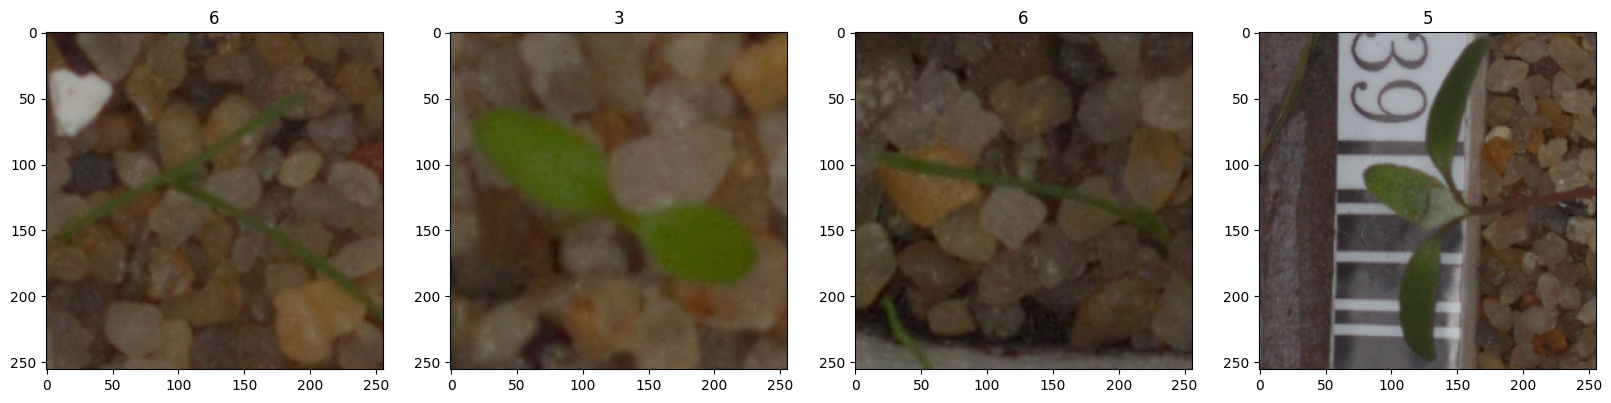

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#Normalizacion 0 a 1

In [60]:
data = data.map(lambda x,y: (x/255, y))

In [61]:
data.as_numpy_iterator().next()

(array([[[[0.36711633, 0.27714658, 0.18947731],
          [0.37666655, 0.2806647 , 0.19820184],
          [0.3709215 , 0.27586177, 0.18482707],
          ...,
          [0.43233353, 0.37053052, 0.29055768],
          [0.40144444, 0.33964142, 0.26105687],
          [0.39679423, 0.3363128 , 0.27710977]],
 
         [[0.35712585, 0.27628407, 0.20109528],
          [0.37147906, 0.28960955, 0.2132151 ],
          [0.33154944, 0.24266896, 0.15150549],
          ...,
          [0.4301494 , 0.36661538, 0.27902523],
          [0.4212105 , 0.35454383, 0.2700003 ],
          [0.39859834, 0.34139636, 0.27823493]],
 
         [[0.35617733, 0.27937347, 0.1991614 ],
          [0.35633606, 0.2760205 , 0.19445644],
          [0.3526927 , 0.277394  , 0.21165195],
          ...,
          [0.38809958, 0.31893045, 0.22920586],
          [0.332204  , 0.26531702, 0.17882216],
          [0.36215925, 0.32086983, 0.25677282]],
 
         ...,
 
         [[0.39120692, 0.23569614, 0.08862004],
          [0.36362

#Separacion de Datos de entrenamiento y Validacion

In [62]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)

In [63]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [64]:
data_dir = 'my_dataset/train'
class_names = sorted(os.listdir(data_dir))

In [65]:
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [66]:
train_resized = train.map(lambda x, y: (tf.image.resize(x, (256, 256)), y))
val_resized = val.map(lambda x, y: (tf.image.resize(x, (256, 256)), y))

In [67]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#VGG

In [68]:
vgg = Sequential()

vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(MaxPooling2D((2, 2)))
vgg.add(Dropout(0.25))

vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(MaxPooling2D((2, 2)))
vgg.add(Dropout(0.25))

vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(MaxPooling2D((2, 2)))
vgg.add(Dropout(0.25))

vgg.add(Flatten())

vgg.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Dropout(0.5))

vgg.add(Dense(450, activation='relu', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Dropout(0.5))

vgg.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
vgg.add(BatchNormalization())
vgg.add(Dropout(0.5))

vgg.add(Dense(len(class_names), activation='softmax'))

vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
Mvgg = vgg.fit(train_resized, epochs=20, validation_data=val_resized,  callbacks=[tensorboard_callback])

Epoch 1/20
316/316 [==============================] - 202s 616ms/step - loss: 4.7840 - accuracy: 0.2294 - val_loss: 6.1010 - val_accuracy: 0.2025
Epoch 2/20
316/316 [==============================] - 189s 594ms/step - loss: 5.4041 - accuracy: 0.3017 - val_loss: 5.7681 - val_accuracy: 0.1899
Epoch 3/20
316/316 [==============================] - 188s 593ms/step - loss: 5.7629 - accuracy: 0.3188 - val_loss: 5.0912 - val_accuracy: 0.0970
Epoch 4/20
316/316 [==============================] - 195s 616ms/step - loss: 6.9285 - accuracy: 0.2661 - val_loss: 6.3154 - val_accuracy: 0.1392
Epoch 5/20
316/316 [==============================] - 188s 593ms/step - loss: 5.6797 - accuracy: 0.3296 - val_loss: 5.8643 - val_accuracy: 0.1719
Epoch 6/20
316/316 [==============================] - 194s 612ms/step - loss: 6.7709 - accuracy: 0.2925 - val_loss: 6.4969 - val_accuracy: 0.2975
Epoch 7/20
316/316 [==============================] - 194s 613ms/step - loss: 6.5800 - accuracy: 0.3318 - val_loss: 6.6232 -

In [69]:
img_path = 'my_dataset/test/0021e90e4.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = vgg.predict(img_array)

predicted_class = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")

1/1 [==============================] - 1s 864ms/step
La imagen es de la clase: Small-flowered Cranesbill


In [70]:
vgg.save('vgg.h5')

In [ ]:
vgg = tf.keras.models.load_model('vgg.h5')

In [ ]:
modelo = "vgg.h5"

files.download(modelo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
ruta_drive = '/content/drive/MyDrive/Modelos/vgg.h5'

vgg.save(ruta_drive)



#ResNet50

In [73]:
MResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

ResNt = Sequential()

ResNt.add(MResNet50)

ResNt.add(GlobalAveragePooling2D())

ResNt.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

ResNt.add(Dropout(0.5))

ResNt.add(BatchNormalization())

ResNt.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
ResNt.add(Dropout(0.4))

ResNt.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
ResNt.add(Dropout(0.5))

ResNt.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
ResNt.add(Dropout(0.4))

ResNt.add(Dense(len(class_names), activation='softmax'))

ResNt.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [74]:
MResNt = ResNt.fit(train_resized, epochs=20, validation_data=val_resized,  callbacks=[tensorboard_callback])

Epoch 1/20
316/316 [==============================] - 139s 316ms/step - loss: 6.6102 - accuracy: 0.1197 - val_loss: 4.5555 - val_accuracy: 0.1382
Epoch 2/20
316/316 [==============================] - 93s 290ms/step - loss: 3.7997 - accuracy: 0.1263 - val_loss: 3.2870 - val_accuracy: 0.0970
Epoch 3/20
316/316 [==============================] - 98s 309ms/step - loss: 2.9670 - accuracy: 0.1416 - val_loss: 2.7404 - val_accuracy: 0.1656
Epoch 4/20
316/316 [==============================] - 98s 310ms/step - loss: 2.5980 - accuracy: 0.1764 - val_loss: 2.5964 - val_accuracy: 0.1276
Epoch 5/20
316/316 [==============================] - 99s 310ms/step - loss: 2.4182 - accuracy: 0.2046 - val_loss: 2.5093 - val_accuracy: 0.1730
Epoch 6/20
316/316 [==============================] - 98s 310ms/step - loss: 2.2548 - accuracy: 0.2381 - val_loss: 3.2178 - val_accuracy: 0.1414
Epoch 7/20
316/316 [==============================] - 98s 310ms/step - loss: 2.1440 - accuracy: 0.2729 - val_loss: 1.9722 - val_a

In [75]:
img_path = 'my_dataset/test/0021e90e4.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


img_array /= 255.0

predictions = ResNt.predict(img_array)

predicted_class = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")

1/1 [==============================] - 1s 936ms/step
La imagen es de la clase: Common Chickweed


#Xception

In [76]:
MXception = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

Xcept = Sequential()

Xcept.add(MXception)

Xcept.add(GlobalAveragePooling2D())

Xcept.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

Xcept.add(Dropout(0.5))

Xcept.add(BatchNormalization())

Xcept.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
Xcept.add(Dropout(0.3))
Xcept.add(BatchNormalization())
Xcept.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
Xcept.add(Dropout(0.4))
Xcept.add(BatchNormalization())
Xcept.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
Xcept.add(Dropout(0.3))
Xcept.add(BatchNormalization())

Xcept.add(Dense(len(class_names), activation='softmax'))

Xcept.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 [==============================] - 0s 0us/step


In [77]:
MXcept = Xcept.fit(train_resized, epochs=20, validation_data=val_resized,  callbacks=[tensorboard_callback])

Epoch 1/20
316/316 [==============================] - 142s 345ms/step - loss: 20.2174 - accuracy: 0.0976 - val_loss: 14.9113 - val_accuracy: 0.1192
Epoch 2/20
316/316 [==============================] - 116s 365ms/step - loss: 10.0486 - accuracy: 0.1084 - val_loss: 8.2446 - val_accuracy: 0.1297
Epoch 3/20
316/316 [==============================] - 117s 367ms/step - loss: 6.1452 - accuracy: 0.1192 - val_loss: 5.1839 - val_accuracy: 0.1350
Epoch 4/20
316/316 [==============================] - 116s 365ms/step - loss: 4.6744 - accuracy: 0.1226 - val_loss: 4.9260 - val_accuracy: 0.1561
Epoch 5/20
316/316 [==============================] - 116s 366ms/step - loss: 3.8721 - accuracy: 0.1382 - val_loss: 3.7715 - val_accuracy: 0.1392
Epoch 6/20
316/316 [==============================] - 116s 364ms/step - loss: 3.5094 - accuracy: 0.1508 - val_loss: 5.8566 - val_accuracy: 0.1329
Epoch 7/20
316/316 [==============================] - 116s 364ms/step - loss: 3.1799 - accuracy: 0.1864 - val_loss: 3.123

In [78]:
img_path = 'my_dataset/test/0021e90e4.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


img_array /= 255.0

predictions = Xcept.predict(img_array)

predicted_class = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")

1/1 [==============================] - 1s 1s/step
La imagen es de la clase: Charlock


#InceptionV3

In [79]:
# modelo InceptionV3
MInceptV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

InceptV3 = Sequential()


InceptV3.add(MInceptV3)

InceptV3.add(GlobalAveragePooling2D())
InceptV3.add(Dense(256, activation='relu'))
InceptV3.add(Dense(len(class_names), activation='softmax'))

InceptV3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [80]:
MInceptV3 = InceptV3.fit(train_resized, epochs=20, validation_data=val_resized,  callbacks=[tensorboard_callback])

Epoch 1/20
316/316 [==============================] - 129s 292ms/step - loss: 1.3477 - accuracy: 0.5746 - val_loss: 6.0686 - val_accuracy: 0.2511
Epoch 2/20
316/316 [==============================] - 93s 294ms/step - loss: 0.6818 - accuracy: 0.7587 - val_loss: 0.6491 - val_accuracy: 0.7932
Epoch 3/20
316/316 [==============================] - 83s 262ms/step - loss: 0.5221 - accuracy: 0.8215 - val_loss: 2.1182 - val_accuracy: 0.5517
Epoch 4/20
316/316 [==============================] - 93s 292ms/step - loss: 0.4293 - accuracy: 0.8473 - val_loss: 1.4771 - val_accuracy: 0.5928
Epoch 5/20
316/316 [==============================] - 87s 272ms/step - loss: 0.3702 - accuracy: 0.8716 - val_loss: 0.5999 - val_accuracy: 0.7901
Epoch 6/20
316/316 [==============================] - 84s 265ms/step - loss: 0.3192 - accuracy: 0.8877 - val_loss: 0.7343 - val_accuracy: 0.7869
Epoch 7/20
316/316 [==============================] - 86s 270ms/step - loss: 0.3001 - accuracy: 0.8943 - val_loss: 3.6196 - val_a

In [81]:
img_path = 'my_dataset/test/0021e90e4.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


img_array /= 255.0

predictions = InceptV3.predict(img_array)

predicted_class = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")

1/1 [==============================] - 8s 8s/step
La imagen es de la clase: Small-flowered Cranesbill


#MobileNetV2

In [82]:
MMobileNV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo preentrenado
for layer in MMobileNV2.layers:
    layer.trainable = False


MobileNV2 = Sequential()

MobileNV2.add(MMobileNV2)

MobileNV2.add(GlobalAveragePooling2D())

MobileNV2.add(Dense(1024, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))

MobileNV2.add(Dropout(0.5))

MobileNV2.add(BatchNormalization())

MobileNV2.add(Dense(512, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))

MobileNV2.add(Dropout(0.4))

MobileNV2.add(BatchNormalization())

MobileNV2.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)))

MobileNV2.add(Dropout(0.3))

MobileNV2.add(BatchNormalization())

MobileNV2.add(Dense(len(class_names), activation='softmax'))

MobileNV2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [2]:
MMobileNV2 = MobileNV2.fit(train_resized, epochs=20, validation_data=val_resized,  callbacks=[tensorboard_callback])

NameError: ignored

In [ ]:
img_path = 'my_dataset/test/0021e90e4.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


img_array /= 255.0

predictions = MobileNV2.predict(img_array)

predicted_class = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")

#DenseNet

In [ ]:
MDenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

DenseNet = Sequential()

DenseNet.add(MDenseNet)

DenseNet.add(GlobalAveragePooling2D())

DenseNet.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))

DenseNet.add(Dropout(0.5))

DenseNet.add(BatchNormalization())

DenseNet.add(Dense(512, activation='relu', kernel_regularizer=l1(0.01)))

DenseNet.add(Dropout(0.3))

DenseNet.add(BatchNormalization())

DenseNet.add(Dense(256, activation='relu', kernel_regularizer=l1(l1=0.01)))

DenseNet.add(Dropout(0.2))

DenseNet.add(BatchNormalization())

DenseNet.add(Dense(len(class_names), activation='softmax'))

DenseNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
MDenseNet = DenseNet.fit(train_resized, epochs=20, validation_data=val_resized,  callbacks=[tensorboard_callback])

In [ ]:
img_path = 'my_dataset/test/0021e90e4.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


img_array /= 255.0

predictions = DenseNet.predict(img_array)

predicted_class = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")

#Graficas de Rendimiento

####VGG

In [ ]:
fig = plt.figure()
plt.plot(Mvgg.history['loss'], color='teal', label='loss')
plt.plot(Mvgg.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
plt.plot(Mvgg.history['accuracy'], color='teal', label='accuracy')
plt.plot(Mvgg.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

####ResNet50

In [ ]:
fig = plt.figure()
plt.plot(MResNt.history['loss'], color='teal', label='loss')
plt.plot(MResNt.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(MResNt.history['accuracy'], color='teal', label='accuracy')
plt.plot(MResNt.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

####Xception

In [ ]:
fig = plt.figure()
plt.plot(MXcept.history['loss'], color='teal', label='loss')
plt.plot(MXcept.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(MXcept.history['accuracy'], color='teal', label='accuracy')
plt.plot(MXcept.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

####InceptionV3

In [ ]:
fig = plt.figure()
plt.plot(MInceptV3.history['loss'], color='teal', label='loss')
plt.plot(MInceptV3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(MInceptV3.history['accuracy'], color='teal', label='accuracy')
plt.plot(MInceptV3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

####MobileNetV2

In [ ]:
fig = plt.figure()
plt.plot(MMobileNV2.history['loss'], color='teal', label='loss')
plt.plot(MMobileNV2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(MMobileNV2.history['accuracy'], color='teal', label='accuracy')
plt.plot(MMobileNV2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

####DenseNet

In [ ]:
fig = plt.figure()
plt.plot(MDenseNet.history['loss'], color='teal', label='loss')
plt.plot(MDenseNet.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(MDenseNet.history['accuracy'], color='teal', label='accuracy')
plt.plot(MDenseNet.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()